In [27]:
'''
Code for paper "Robustness and Reliability of Gender Bias Assessment in Word Embeddings: The Role of Base Pairs",
by Haiyang Zhang, Alison Sneyd and Mark Stevenson, AACL 2020

Code authors: Alison Sneyd and Haiyang Zhang
'''

# imports
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import string 
import numpy as np
import json
import pandas as pd
import math
from collections import Counter
import matplotlib.pyplot as plt
import re
import random
from sklearn.metrics import cohen_kappa_score
import scipy.stats

%matplotlib inline

In [2]:
# LOAD INPUT DATA

# load word embeddings from file
model = KeyedVectors.load_word2vec_format('input_data/GoogleNews-vectors-negative300.bin', binary=True)
model.init_sims()
model_normed = KeyedVectors.load_word2vec_format('input_data/GoogleNews-vectors-negative300.bin', binary=True)
model_normed.init_sims(replace=True)



In [3]:
#  Bolukbasi list professions
with open('input_data/professions.json', 'r') as f:
        professions = json.load(f)
professions = [professions[i][0] for i in range(len(professions))] # list

# BSRI female
with open('input_data/bem_female_forms.txt', 'r') as f:
        bem_female_forms = json.load(f)  # dictionary word:variants
bem_female = [] # words in dict values to list
for v in bem_female_forms.values():
    for word in v:
        bem_female.append(word)

#  BSRI male        
with open('input_data/bem_male_forms.txt', 'r') as f:
        bem_male_forms = json.load(f)  # dictionary word:variants
bem_male = []
for v in bem_male_forms.values():
    for word in v:
        bem_male.append(word)
        
# female animals
with open('input_data/frequent_female_animals.txt', 'r') as f: 
    f_animals = json.load(f) # list

# female animals
with open('input_data/frequent_male_animals.txt', 'r') as f:
    m_animals = json.load(f) # list

        
# Bolukbasi list of gender specific words       
with open('input_data/gender_specific_full.json') as f:
    gender_specific = json.load(f)


#  Bolukbasi long list of gender pairs
with open('input_data/equalize_pairs.json') as f:
    equalize_pairs = json.load(f)
    
# test analogies file
with open("input_data/word-test.v1.txt", 'r') as infile:
    analogs = infile.readlines()
        
        
# make list defining gender pairs
# for measures & this list, + = female, - = male
def_pairs = [('she','he'), ('her', 'his'), ('woman', 'man'), ('mary', 'john'),
              ('herself', 'himself'),('daughter', 'son'), ('mother', 'father'), ('gal','guy'), 
              ('girl', 'boy'), ('female', 'male')]


In [5]:
# DEFINE REDUCED VOCBULARIES

def safe_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-zA-Z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))

def netural_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))

def limit_vocab(model, exclude = None):
    vocab_limited = []
    vocab_neutral = []
    for w in model.wv.index2entity[:50000]: 
        if safe_word(w) == True:
             vocab_limited.append(w)
        if netural_word(w) == True:
            vocab_neutral.append(w)
        
    if exclude:
        vocab_neutral = list(set(vocab_neutral) - set(exclude))
  

    print("size of limited vocabulary:", len(vocab_limited))
    
    wv_vocab = np.zeros((len(vocab_limited), 300))
    for i,w in enumerate(vocab_limited):
        wv_vocab[i,:] = model[w]
    
    wv_neutral = np.zeros((len(vocab_neutral), 300))
    for i,w in enumerate(vocab_neutral):
        wv_neutral[i,:] = model[w]
        
        
            
    w2i_neutral = {w: i for i, w in enumerate(vocab_neutral)}
    i2w_neutral = {i:w for w, i in w2i_neutral.items()}
    
    return vocab_limited, wv_vocab, vocab_neutral, wv_neutral, w2i_neutral, i2w_neutral


exclude_words = []
for pair in def_pairs + equalize_pairs:
    exclude_words.append(pair[0])
    exclude_words.append(pair[1])
exclude_words = list(set(exclude_words).union(set(gender_specific)))


vocab_limited, wv_vocab, vocab_neutral, wv_neutral, w2i_neutral, i2w_neutral = limit_vocab(model_normed, exclude_words)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


size of limited vocabulary: 48088


In [6]:
# DEFINE GENDER BIAS MEASURE FUNCTIONS

# Bolukbasi direct bias/ Caliskan word association with one base pair
def bdb(word, pair):
    word = model[word]/np.linalg.norm(model[word]) 
    pair0 = model[pair[0]]/np.linalg.norm(model[pair[0]])
    pair1 = model[pair[1]]/np.linalg.norm(model[pair[1]])
    db = np.dot(word, pair0-pair1)
    return db


# used to calculate ripa score
def b_vec(word_pair): 
    word1 = word_pair[0]
    word2 = word_pair[1]
    vec = model[word1] - model[word2]
    norm = np.linalg.norm(vec)
    
    return vec/norm


# RIPA bias measure with one base pair
def ripa1(word, bvec):
    word_vec = model[word]
    
    return np.dot(word_vec, bvec)


# NBM get gender direction with specified neutral vocab and base pair
def compute_bias_by_projection(def_pair, vecs = wv_neutral, vocab = vocab_neutral):
    females = vecs.dot(model_normed[def_pair[0]])
    males = vecs.dot(model_normed[def_pair[1]])
    d = {}
    for w,m,f in zip(vocab, males, females):
        d[w] = f-m
    return d



# NBM get neiighbours
def topK(w, k=10):
    
    # extract the word vector for word w
    # idx = w2i_limited[w]
    # vec = wv_limited[idx, :]
    
    vec = model_normed[w]
    # compute similarity of w with all words in the restricted vocabulary
    sim = wv_neutral.dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [i2w_neutral[i] for i in best if i2w_neutral[i]!=w]



# NBM: get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)
def bias_by_neighbors(target_words,gender_bias, neighbours_num = 100):
    
    tuples = []
    neighbor_bias = {}
    for w in target_words:
        
        top = topK(w, k=neighbours_num+5)[:neighbours_num]
        
        m = 0
        f = 0    
        for t in top:
            if gender_bias[t] > 0:
                f+=1
            else:
                m+=1
        neighbor_bias[w] = (f-m)/(f+m)

        tuples.append((w, m, f, (f-m)/(f+m)))

    return neighbor_bias


# make dictionary of DB/WA scores for base pair list (keys) and vocab list
def make_bdb_scores_dict(word_pairs, word_list):
    bdb_scores = {}

    for pair in word_pairs:
        bdb_scores[pair] = []

        for word in word_list:
            score = bdb(word, pair)
            bdb_scores[pair].append(score)
            
    return bdb_scores

# make dictionary of RIPA scores for base pair list (keys) and vocab list
def make_ripa_scores_dict(word_pairs, word_list):
    ripa_scores = {}

    for pair in word_pairs:
        ripa_scores[pair] = []

        for word in word_list:
            bvec = b_vec(pair)
            score = ripa1(word, bvec)
            ripa_scores[pair].append(score)
            
    return ripa_scores

# make dictionary of NBM scores for base pair list (keys) and vocab list
def make_nbm_scores_dict(word_pairs, word_list):
    nbm_scores = {}
  
    for pair in word_pairs:
        direct_bias = compute_bias_by_projection(pair)
        nbm = bias_by_neighbors(word_list,direct_bias, neighbours_num = 100)
        nbm_scores[pair]=list(nbm.values())

            
    return nbm_scores

In [7]:
# MAKE SCORE DICTIONARIES
bdb_profs_scores = make_bdb_scores_dict(def_pairs, professions)
ripa_profs_scores = make_ripa_scores_dict(def_pairs, professions)
nbm_profs_scores = make_nbm_scores_dict(def_pairs, professions)

bdb_bf_scores = make_bdb_scores_dict(def_pairs, bem_female)
bdb_bm_scores = make_bdb_scores_dict(def_pairs, bem_male)
ripa_bf_scores = make_ripa_scores_dict(def_pairs, bem_female)
ripa_bm_scores = make_ripa_scores_dict(def_pairs, bem_male)
nbm_bf_scores = make_nbm_scores_dict(def_pairs, bem_female)
nbm_bm_scores = make_nbm_scores_dict(def_pairs, bem_male)

bdb_af_scores = make_bdb_scores_dict(def_pairs, f_animals)
bdb_am_scores = make_bdb_scores_dict(def_pairs, m_animals)
ripa_af_scores = make_ripa_scores_dict(def_pairs, f_animals)
ripa_am_scores = make_ripa_scores_dict(def_pairs, m_animals)
nbm_af_scores = make_nbm_scores_dict(def_pairs, f_animals)
nbm_am_scores = make_nbm_scores_dict(def_pairs, m_animals)


# convert dictionaries to dfs
df_bdb_prof = pd.DataFrame.from_dict(bdb_profs_scores, orient='index', columns = professions).T
df_ripa_prof = pd.DataFrame.from_dict(ripa_profs_scores, orient='index', columns = professions).T
df_nbm_prof = pd.DataFrame.from_dict(nbm_profs_scores, orient='index', columns = professions).T

df_bdb_bemf = pd.DataFrame.from_dict(bdb_bf_scores, orient='index', columns = bem_female).T
df_bdb_bemm = pd.DataFrame.from_dict(bdb_bm_scores, orient='index', columns = bem_male).T
df_ripa_bemf = pd.DataFrame.from_dict(ripa_bf_scores, orient='index', columns = bem_female).T
df_ripa_bemm = pd.DataFrame.from_dict(ripa_bm_scores, orient='index', columns = bem_male).T
df_nbm_bemf = pd.DataFrame.from_dict(nbm_bf_scores, orient='index', columns = bem_female).T
df_nbm_bemm = pd.DataFrame.from_dict(nbm_bm_scores, orient='index', columns = bem_male).T

df_bdb_anf = pd.DataFrame.from_dict(bdb_af_scores, orient='index', columns = f_animals).T
df_bdb_anm = pd.DataFrame.from_dict(bdb_am_scores, orient='index', columns = m_animals).T
df_ripa_anf = pd.DataFrame.from_dict(ripa_af_scores, orient='index', columns = f_animals).T
df_ripa_anm = pd.DataFrame.from_dict(ripa_am_scores, orient='index', columns = m_animals).T
df_nbm_anf = pd.DataFrame.from_dict(nbm_af_scores, orient='index', columns = f_animals).T
df_nbm_anm = pd.DataFrame.from_dict(nbm_am_scores, orient='index', columns = m_animals).T

In [8]:
# GET OVERALL MEANS AND STANDARD DEVIATIONS OF BIAS MEASURES IN EMBEDDINGS

print("Vocab size:", len(vocab_limited))

# computer DB/WA mean and std
vocab_bdb = {}
for pair in def_pairs:
    vocab_bdb[pair] = []
    for word in vocab_limited:
        vocab_bdb[pair].append(bdb(word, pair))

all_bdb_scores =[]
for k in vocab_bdb.keys():
    for v in vocab_bdb[k]:
        all_bdb_scores.append(v)
        
bdb_oa_mean = np.mean(all_bdb_scores)
bdb_oa_std = np.std(all_bdb_scores)
print("DB/WA overall mean and std:", bdb_oa_mean, bdb_oa_std)


# computer RIPA mean and std
vocab_ripa = {}
for pair in def_pairs:
    vocab_ripa[pair] = []
    for word in vocab_limited:
        vocab_ripa[pair].append(ripa1(word, b_vec(pair)))

all_ripa_scores =[]
for k in vocab_ripa.keys():
    for v in vocab_ripa[k]:
        all_ripa_scores.append(v)
        
ripa_oa_mean = np.mean(all_ripa_scores)
ripa_oa_std = np.std(all_ripa_scores)
print("RIPA overall mean and std:", ripa_oa_mean, ripa_oa_std)



# computer NBM mean and std
all_nbm_scores =[]

for pair in def_pairs:
    direct_bias = compute_bias_by_projection(pair, wv_vocab, vocab_limited)
    nbm = bias_by_neighbors(vocab_limited,direct_bias, neighbours_num = 100)
    nbm_bias = list(nbm.values())
    all_nbm_scores.append(nbm_bias)

nbm_oa_mean = np.mean(all_nbm_scores)
nbm_oa_std = np.std(all_nbm_scores)
print("NBM overall mean and std:", nbm_oa_mean, nbm_oa_std)

Vocab size: 48088
DB/WA overall mean and std: -0.0011582847 0.05253422
RIPA overall mean and std: 0.024363615 0.23856565
NBM overall mean and std: -0.03782977042089502 0.43090597471356806


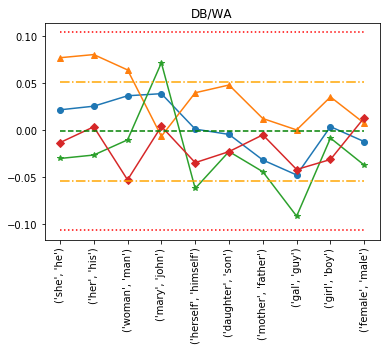

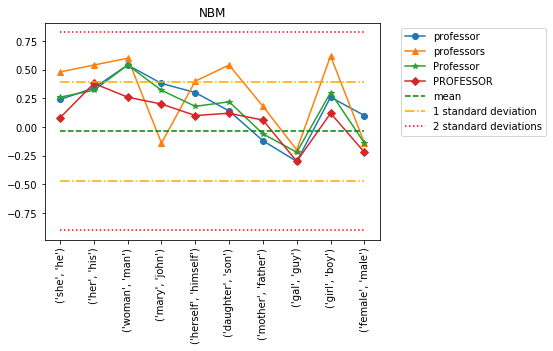

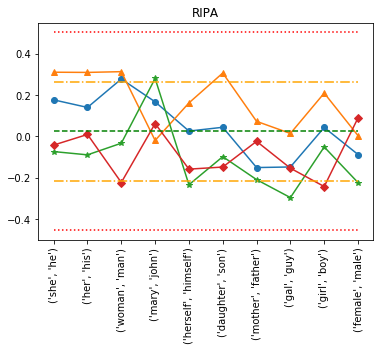

In [9]:
# MAKE SCORE GRAPHS

# fn to plot scores of word list for a given measure and list of base pairs
def make_mag_plot_gen(gword_list, measure, pair_list, leg = False):

    length = len(pair_list)
    x = np.arange(length)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    graph_types = ["-o", "-^", "-*", "-D"]
    
    for i,word in enumerate(gword_list):
        graph_type = graph_types[i]

        if measure == "bdb":
            oa_mean = bdb_oa_mean
            oa_std = bdb_oa_std
            plt.title("DB/WA")
            scores = [bdb(word, pair) for pair in pair_list]
        elif measure == "ripa1":
            plt.title("RIPA")
            oa_mean = ripa_oa_mean
            oa_std = ripa_oa_std
            scores = [ripa1(word, b_vec(pair)) for pair in pair_list]
        elif measure == 'nbm':
            plt.title("NBM")
            oa_mean = nbm_oa_mean
            oa_std = nbm_oa_std
            scores = make_nbm_scores_dict(def_pairs, [word])
            scores = [scores[pair][0] for pair in pair_list]
            
        else:
            print("Error- bad measure")
        plt.plot(x, scores, graph_type, label = word)


    plt.plot(x, [oa_mean for i in range(length)], "g--", label = "mean")
    plt.plot(x, [oa_mean-oa_std for i in range(length)], "-.",color = "orange", label = "1 standard deviation")
    plt.plot(x, [oa_mean+oa_std for i in range(length)],  "-.",color = "orange", label =  "")
    plt.plot(x, [oa_mean-2*oa_std for i in range(length)],  "r:", label = "2 standard deviations")
    plt.plot(x, [oa_mean+2*oa_std for i in range(length)],  "r:", label = "")
    plt.xticks(x, pair_list, rotation='vertical')

    if leg == True:
        plt.legend()
        ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.show()


# fn to get variant forms of profession (eg for doctor, returns doctor, doctors, Doctor, DOCTOR)   
def prof_words(prof):
    prof_words = [prof]
    if prof+"s" in model.vocab:
        prof_words.append(prof+"s")
    elif prof+"es" in model.vocab:
        prof_words.append(prof+"es")
    prof_words.append(prof.capitalize())
    prof_words.append(prof.upper())
    return prof_words


# make plots showing bias score variation
make_mag_plot_gen(prof_words("professor"), "bdb", def_pairs)
make_mag_plot_gen(prof_words("professor"), "nbm", def_pairs, leg = True)
make_mag_plot_gen(prof_words("professor"), "ripa1", def_pairs)

In [10]:
# COMPUTE MAGNITUDE CHANGES

def mag_changes(df_prof, std):
    profs_dict = df_prof.to_dict('index')
    mcs = {}
    for prof in profs_dict.keys():
        c = 0
        for i,pair1 in enumerate(def_pairs):
            p1_score = profs_dict[prof][pair1]
            for pair2 in def_pairs[i+1:]:
                p2_score = profs_dict[prof][pair2]
                if abs(p1_score - p2_score) >= std:
                    c += 1
        mcs[prof] = c#int(c/2)
    mean = np.mean([v for v in mcs.values()])
    return (round(1 - mean/45,2))

print("DB/WA mag changes on professions:", mag_changes(df_bdb_prof, bdb_oa_std))
print("RIPA mag changes on professions:", mag_changes(df_ripa_prof, ripa_oa_std))
print("RIPA mag changes on professions:", mag_changes(df_nbm_prof, nbm_oa_std))

DB/WA mag changes on professions: 0.69
RIPA mag changes on professions: 0.66
RIPA mag changes on professions: 0.71


In [11]:
# BASE PAIR AGREEMENT FOR PROFESSIONS

'''
Fn to calculate Fleiss kappa coefficient
Input is numpy matrix, rows are items rated, colums are rating categories (eg 0,1)
Entries are number of annotators who rated given item as given category
https://en.wikipedia.org/wiki/Fleiss'_kappa
https://www.datanovia.com/en/lessons/fleiss-kappa-in-r-for-multiple-categorical-variables/
'''
def fleiss_kappa(M): 
    
    n_annotators = np.sum(M[0, :]) 
    n_items_rated = M.shape[0]
    n_rating_categories = M.shape[1]
    total_n_ratings = n_items_rated*n_annotators
    
    #  row vec of proportions p_i of all ratings given to each rating category
    p = M.sum(axis = 0)/total_n_ratings
    
    # column vec of rating agreements P_j for each item
    P = (np.sum(np.multiply(M,M), axis = 1)- n_annotators)/(n_annotators*(n_annotators-1))
       
    P_o = np.mean(P) # observed agreement
    P_e = np.sum(np.multiply(p,p)) # expected agreement
    kappa = (P_o - P_e) / (1 - P_e) # agreement
    
    return round(kappa,2)


# turn bias scores to directions (male or female)
def make_binary(df):
    binary_df = df.copy()
    binary_df[binary_df<0] = 0
    binary_df[binary_df>0] = 1
    return binary_df


# compute fleiss kappa of df
def compute_fleiss_kappa(df):
    col_dict = {c:df.iloc[:,c].tolist() for c in range(df.shape[1])}

    k0 = np.zeros(df.shape[0])
    k1 = np.zeros(df.shape[0])

    for i in range(df.shape[0]):
        for c in range(df.shape[1]):

            if col_dict[c][i] == 0:
                k0[i] += 1
            else:
                k1[i] +=1

    M = np.matrix([k0,k1]).T
    return fleiss_kappa(M)


print("DB/WA:", compute_fleiss_kappa(make_binary(df_bdb_prof)))
print("RIPA:", compute_fleiss_kappa(make_binary(df_ripa_prof)))
print("NB:", compute_fleiss_kappa(make_binary(df_nbm_prof)))

DB/WA: 0.45
RIPA: 0.42
NB: 0.29


In [12]:
# DIFFERENT FORMS BASE PAIRS
# compare profession scores with using capitalized versions of base pairs eg (she, he) vs (She, He)

cap_def_pairs = [(fp.capitalize(), mp.capitalize()) for fp,mp in def_pairs]

# kappa for only two classes
def cohen_kappa(orign_df, vary_df):
    scores = []
    for i in range(len(orign_df.columns)):
        pair_cohen=cohen_kappa_score(orign_df[orign_df.columns[i]], vary_df[vary_df.columns[i]])
        scores.append(pair_cohen)
        print('& %.2f '%(pair_cohen), end=' ')
    print('& %.2f '%(np.mean(scores)))

# make score dataframes
bdb_profs_scores_cap = make_bdb_scores_dict(cap_def_pairs, professions)
ripa_profs_scores_cap = make_ripa_scores_dict(cap_def_pairs, professions)
nbm_profs_scores_cap = make_nbm_scores_dict(cap_def_pairs, professions)
df_bdb_prof_cap = pd.DataFrame.from_dict(bdb_profs_scores_cap, orient='index', columns = professions).T
df_ripa_prof_cap = pd.DataFrame.from_dict(ripa_profs_scores_cap, orient='index', columns = professions).T
df_nbm_prof_cap = pd.DataFrame.from_dict(nbm_profs_scores_cap, orient='index', columns = professions).T

print("GD/WA")
cohen_kappa(make_binary(df_bdb_prof),make_binary(df_bdb_prof_cap))
print("RIPA")
cohen_kappa(make_binary(df_ripa_prof),make_binary(df_ripa_prof_cap))
print("NBM")
cohen_kappa(make_binary(df_nbm_prof),make_binary(df_nbm_prof_cap))

GD/WA
& 0.65  & 0.53  & 0.56  & 0.32  & 0.60  & 0.28  & 0.40  & 0.03  & 0.49  & 0.38  & 0.42 
RIPA
& 0.80  & 0.56  & 0.58  & 0.32  & 0.59  & 0.27  & 0.31  & 0.04  & 0.49  & 0.35  & 0.43 
NBM
& 0.58  & 0.65  & 0.61  & 0.19  & 0.69  & 0.18  & 0.23  & 0.10  & 0.53  & 0.18  & 0.39 


In [13]:
# PROFESSION VARIANT FORM EXPERIMENTS (PLURAL, CAPITALISED, UPPERCASE VS BASE)
# eg compare bias direction professor to professors, Professor, PROFESSOR

# define reduced professions list (whose variants are in vocab)
professions_variants_base = []
professions_variants_cap = []
professions_variants_upper = []
professions_variants_pl = []
for prof in professions:
    if prof.upper() in model.vocab:
        if prof.capitalize() in model.vocab:
            if prof+"s" in model.vocab:
                professions_variants_base.append(prof)
                professions_variants_cap.append(prof.capitalize())
                professions_variants_upper.append(prof.upper())
                professions_variants_pl.append(prof+"s")
            elif prof+"es" in model.vocab:
                professions_variants_base.append(prof)
                professions_variants_cap.append(prof.capitalize())
                professions_variants_upper.append(prof.upper())
                professions_variants_pl.append(prof+"es")
print(len(professions_variants_base))

# base form words
bdb_profsvb_scores = make_bdb_scores_dict(def_pairs, professions_variants_base)
ripa_profsvb_scores = make_ripa_scores_dict(def_pairs, professions_variants_base)
nbm_profsvb_scores = make_nbm_scores_dict(def_pairs, professions_variants_base)
df_bdb_profvb = pd.DataFrame.from_dict(bdb_profsvb_scores, orient='index', columns = professions_variants_base).T
df_ripa_profvb = pd.DataFrame.from_dict(ripa_profsvb_scores, orient='index', columns = professions_variants_base).T
df_nbm_profvb = pd.DataFrame.from_dict(nbm_profsvb_scores, orient='index', columns = professions_variants_base).T


# plural form words
bdb_profspl_scores = make_bdb_scores_dict(def_pairs, professions_variants_pl)
ripa_profspl_scores = make_ripa_scores_dict(def_pairs, professions_variants_pl)
nbm_profspl_scores = make_nbm_scores_dict(def_pairs, professions_variants_pl)
df_bdb_profpl = pd.DataFrame.from_dict(bdb_profspl_scores, orient='index', columns = professions_variants_base).T
df_ripa_profpl = pd.DataFrame.from_dict(ripa_profspl_scores, orient='index', columns = professions_variants_base).T
df_nbm_profpl = pd.DataFrame.from_dict(nbm_profspl_scores, orient='index', columns = professions_variants_base).T

print("Base vs Plural")
print("DB/WA")
cohen_kappa(make_binary(df_bdb_profvb),make_binary(df_bdb_profpl))
print("RIPA")
cohen_kappa(make_binary(df_ripa_profvb),make_binary(df_ripa_profpl))
print("NBM")
cohen_kappa(make_binary(df_nbm_profvb),make_binary(df_nbm_profpl))


# capital form words
bdb_profscap_scores = make_bdb_scores_dict(def_pairs, professions_variants_cap)
ripa_profscap_scores = make_ripa_scores_dict(def_pairs, professions_variants_cap)
nbm_profscap_scores = make_nbm_scores_dict(def_pairs, professions_variants_cap)
df_bdb_profcap = pd.DataFrame.from_dict(bdb_profscap_scores, orient='index', columns = professions_variants_base).T
df_ripa_profcap = pd.DataFrame.from_dict(ripa_profscap_scores, orient='index', columns = professions_variants_base).T
df_nbm_profcap = pd.DataFrame.from_dict(nbm_profscap_scores, orient='index', columns = professions_variants_base).T

print("\n")
print("Base vs Capital")
print("DB/WA")
cohen_kappa(make_binary(df_bdb_profvb),make_binary(df_bdb_profcap))
print("RIPA")
cohen_kappa(make_binary(df_ripa_profvb),make_binary(df_ripa_profcap))
print("NBM")
cohen_kappa(make_binary(df_nbm_profvb),make_binary(df_nbm_profcap))


# uppercase form words
bdb_profsup_scores = make_bdb_scores_dict(def_pairs, professions_variants_upper)
ripa_profsup_scores = make_ripa_scores_dict(def_pairs, professions_variants_upper)
nbm_profsup_scores = make_nbm_scores_dict(def_pairs, professions_variants_upper)
df_bdb_profup = pd.DataFrame.from_dict(bdb_profsup_scores, orient='index', columns = professions_variants_base).T
df_ripa_profup = pd.DataFrame.from_dict(ripa_profsup_scores, orient='index', columns = professions_variants_base).T
df_nbm_profup = pd.DataFrame.from_dict(nbm_profsup_scores, orient='index', columns = professions_variants_base).T

print("\n")
print("Base vs Upper")
print("DB/WA")
cohen_kappa(make_binary(df_bdb_profvb),make_binary(df_bdb_profup))
print("RIPA")
cohen_kappa(make_binary(df_ripa_profvb),make_binary(df_ripa_profup))
print("NBM")
cohen_kappa(make_binary(df_nbm_profvb),make_binary(df_nbm_profup))

230
Base vs Plural
DB/WA
& 0.50  & 0.51  & 0.53  & 0.35  & 0.47  & 0.33  & 0.42  & 0.47  & 0.52  & 0.53  & 0.46 
RIPA
& 0.57  & 0.58  & 0.63  & 0.39  & 0.53  & 0.46  & 0.44  & 0.53  & 0.53  & 0.50  & 0.52 
NBM
& 0.69  & 0.57  & 0.72  & 0.38  & 0.65  & 0.32  & 0.50  & 0.59  & 0.60  & 0.62  & 0.56 


Base vs Capital
DB/WA
& 0.61  & 0.66  & 0.59  & 0.42  & 0.67  & 0.79  & 0.61  & 0.50  & 0.50  & 0.44  & 0.58 
RIPA
& 0.60  & 0.60  & 0.54  & 0.36  & 0.59  & 0.69  & 0.61  & 0.54  & 0.53  & 0.45  & 0.55 
NBM
& 0.77  & 0.63  & 0.68  & 0.54  & 0.74  & 0.68  & 0.61  & 0.71  & 0.65  & 0.63  & 0.66 


Base vs Upper
DB/WA
& 0.19  & 0.35  & 0.43  & 0.17  & 0.29  & 0.48  & 0.18  & 0.20  & 0.34  & 0.30  & 0.29 
RIPA
& 0.35  & 0.38  & 0.40  & 0.16  & 0.35  & 0.53  & 0.22  & 0.20  & 0.30  & 0.27  & 0.32 
NBM
& 0.50  & 0.52  & 0.49  & 0.25  & 0.52  & 0.40  & 0.22  & 0.46  & 0.54  & 0.13  & 0.40 


In [14]:
# BSRI GROUNDTRUTH VERSUS PREDICTED

# varient of cohen kappa to compare df against groundtruth list
def ground_cohen_kappa(bias_df, ground):
    scores = []
    for pair in bias_df.columns:
        pair_cohen=cohen_kappa_score(ground, bias_df[pair].tolist())
        scores.append(pair_cohen)
        print('& %.2f '%(pair_cohen), end=' ')
    print('& %.2f '%(np.mean(scores)))


# define groundtruth
ground_female = [1.0 for i in range(len(bem_female))]
ground_male = [0.0 for i in range(len(bem_male))]
ground = ground_female + ground_male

print("DB/WA")
bdb_female_bem = make_binary(df_bdb_bemf)
bdb_male_bem = make_binary(df_bdb_bemm)
bdb_bem = bdb_female_bem.append(bdb_male_bem)
ground_cohen_kappa(bdb_bem, ground)

print("RIPA")
ripa_female_bem = make_binary(df_ripa_bemf)
ripa_male_bem = make_binary(df_ripa_bemm)
ripa_bem = ripa_female_bem.append(ripa_male_bem)
ground_cohen_kappa(ripa_bem, ground)

print("NBM")
nbm_female_bem = make_binary(df_nbm_bemf)
nbm_male_bem = make_binary(df_nbm_bemm)
nbm_bem = nbm_female_bem.append(nbm_male_bem)
ground_cohen_kappa(nbm_bem, ground)


DB/WA
& 0.35  & 0.37  & 0.07  & -0.03  & 0.14  & 0.03  & 0.45  & 0.39  & -0.08  & 0.01  & 0.17 
RIPA
& 0.44  & 0.40  & 0.09  & -0.08  & 0.12  & 0.16  & 0.45  & 0.39  & -0.08  & 0.01  & 0.19 
NBM
& 0.27  & 0.32  & -0.01  & 0.01  & 0.27  & 0.17  & 0.46  & 0.14  & 0.18  & -0.04  & 0.18 


In [15]:
# ANIMAL GROUNDTRUTH VERSUS PREDICTED

# define groundtruth
ground_female = [1.0 for i in range(len(f_animals))]
ground_male = [0.0 for i in range(len(m_animals))]
ground = ground_female + ground_male

print("DB/WA")
bdb_female_ani = make_binary(df_bdb_anf)
bdb_male_ani = make_binary(df_bdb_anm)
bdb_ani = bdb_female_ani.append(bdb_male_ani)
ground_cohen_kappa(bdb_ani, ground)

print("RIPA")
ripa_female_ani = make_binary(df_ripa_anf)
ripa_male_ani = make_binary(df_ripa_anm)
ripa_ani = ripa_female_ani.append(ripa_male_ani)
ground_cohen_kappa(ripa_ani, ground)


print("NBM")
nbm_female_ani = make_binary(df_nbm_anf)
nbm_male_ani = make_binary(df_nbm_anm)
nbm_ani = nbm_female_ani.append(nbm_male_ani)
ground_cohen_kappa(nbm_ani, ground)

DB/WA
& 0.54  & 0.38  & 0.54  & 0.54  & 0.54  & 0.31  & 0.23  & 0.46  & 0.54  & 0.08  & 0.42 
RIPA
& 0.31  & 0.38  & 0.31  & 0.46  & 0.46  & 0.23  & 0.23  & 0.54  & 0.46  & 0.08  & 0.35 
NBM
& 0.31  & 0.08  & 0.15  & 0.15  & 0.15  & 0.00  & 0.08  & 0.46  & 0.15  & 0.00  & 0.15 


In [16]:
# COMPARE AGREEMENTS BETWEEN MEASURES

print("DB/WA & RIPA")
cohen_kappa(make_binary(df_bdb_prof),make_binary(df_ripa_prof))
print("DB/WA & NBM")
cohen_kappa(make_binary(df_bdb_prof),make_binary(df_nbm_prof))
print("RIPA & NBM")
cohen_kappa(make_binary(df_ripa_prof),make_binary(df_nbm_prof))

DB/WA & RIPA
& 0.69  & 0.86  & 0.64  & 0.90  & 0.82  & 0.79  & 0.92  & 0.85  & 0.89  & 0.96  & 0.83 
DB/WA & NBM
& 0.54  & 0.37  & 0.62  & 0.44  & 0.55  & 0.54  & 0.46  & 0.34  & 0.48  & 0.47  & 0.48 
RIPA & NBM
& 0.52  & 0.42  & 0.66  & 0.41  & 0.57  & 0.57  & 0.47  & 0.29  & 0.47  & 0.50  & 0.49 


In [20]:
# CORRELATION BETWEEN COSINE SIIMILARITY OF BASE PAIR DIFFERENCE AND THE CORREPSPONDING KAPPA FOR DB/WA PROFESSIONS
# E.G. FOR (she, he), COS(SHE-HE, FEMALE-MALE), COS(SHE-HE, WOMAN-MAN)... VS. KAPPA(DB(SHE,HE), DB(FEMALE, MALE)), ...

# get cosine sim for between base pairs 
def unit_vector(vec):
    """
    Returns unit vector
    """
    return vec / np.linalg.norm(vec)

def cos(a, b):
    a = unit_vector(a)
    b = unit_vector(b)
    return a.dot(b) #np.clip(np.tensordot(a, b, axes=(-1, -1)), -1.0, 1.0)

pais_diffs = []
for pair1 in def_pairs:
    pair_diff = []
    for pair2 in def_pairs:
        d = cos(model_normed[pair1[0]]-model_normed[pair1[1]],model_normed[pair2[0]]-model_normed[pair2[1]])
        pair_diff.append(d)
    pais_diffs.append(pair_diff)
    
#COMPUTE KAPPA SCORE BWTWEEN PAIRS (COLUMNS IN df_bdb_prof)
bdb_kappa = []
binary_bdb_prof = make_binary(df_bdb_prof)
for i in range(len(binary_bdb_prof.columns)):
    one_pair_kappas = []
    for j in range(len(binary_bdb_prof.columns)):
        pair_cohen = cohen_kappa_score(binary_bdb_prof[binary_bdb_prof.columns[i]], binary_bdb_prof[binary_bdb_prof.columns[j]])
        one_pair_kappas.append(pair_cohen)
    bdb_kappa.append(one_pair_kappas)


In [38]:
def pearson(a,b):
    return scipy.stats.pearsonr(a,b)

def correlation(cos_diff, kappa):
    corrs = []
    for i in range(10):
        corr = pearson(cos_diff[i], kappa[i])
        corrs.append(corr)
    return corrs

bdb_cos_corr = correlation(pais_diffs, bdb_kappa)
bdb_cos_corr

[(0.9669040468961793, 5.043408591227724e-06),
 (0.9468440850032178, 3.274982423860227e-05),
 (0.9117519150137079, 0.00023825935115702782),
 (0.9671062186457328, 4.922508107547368e-06),
 (0.9365012085272753, 6.58501399680708e-05),
 (0.807958583984516, 0.004685970976516724),
 (0.9595290774626636, 1.1176377131905789e-05),
 (0.9090903340048172, 0.00026744534416823693),
 (0.9408284881385657, 4.99174559594801e-05),
 (0.9775724210881374, 1.0773855104206522e-06)]

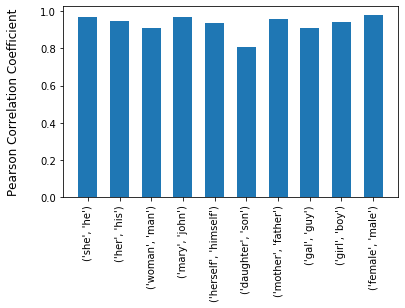

In [40]:
plt.figure(figsize=(6,5))
bdb_corr = [t[0] for t in bdb_cos_corr]

x = np.arange(10)

plt.bar(x, bdb_corr , width=0.6,  align='center', label = 'GD/WA' )

plt.ylabel("Pearson Correlation Coefficient", labelpad=20, size=12)
# plt.xticks(x, ['-'.join(a) for a in attribute_pairs],  rotation='vertical', size = 12)
plt.xticks(x, def_pairs,  rotation='vertical')

#plt.legend(loc='upper center', prop = {'size': 12}, bbox_to_anchor=(0.5, 1.05),
#          ncol=4, fancybox=True, shadow=True)
plt.gcf().subplots_adjust(bottom=0.35, hspace = 0, wspace = 0)

plt.show()

In [41]:
# EXAMPLE INCONSISTENCIES
# negative score = male bias, positive score = female bias

print(ripa1("surgeon", b_vec(("she", "he"))), ripa1("surgeon", b_vec(("woman", "man"))))
print(bdb("surgeon",("she", "he")), bdb("surgeons", ("she", "he")))
direct_bias = compute_bias_by_projection(("woman","man"), wv_vocab, vocab_limited)
print(bias_by_neighbors(["bull", "compassionate", "compassionately"],direct_bias, neighbours_num = 100))

-0.17162736 0.26936823
-0.081630945 0.010357198
{'bull': 0.14, 'compassionate': -0.16, 'compassionately': 0.18}


In [19]:
# PERCENTAGE PROFESSION SAME BIAS DIRECTION FOR ALL BASE PAIRS 

print("DB/WA:", 100*len([1 for i in make_binary(df_bdb_prof).sum(axis=1).tolist() if i in [0,10]])/320)
print("RIPA:", 100*len([1 for i in make_binary(df_ripa_prof).sum(axis=1).tolist() if i in [0,10]])/320)
print("NBM:", 100*len([1 for i in make_binary(df_nbm_prof).sum(axis=1).tolist() if i in [0,10]])/320)

DB/WA: 25.9375
RIPA: 24.0625
NBM: 14.6875


In [20]:
# PERCENTAGE PROFESSIONS CHANGE RIPA DIRECTION W/ BASE PAIR ("woman", "man") VS ("queen", "king")

ripa_profs_scores_qk = make_ripa_scores_dict([("woman", "man"), ("queen", "king")], professions)
df_ripa_prof_qk = pd.DataFrame.from_dict(ripa_profs_scores_qk, orient='index', columns = professions).T
print("% change:", 100-100*len([1 for i in make_binary(df_ripa_prof_qk).sum(axis=1).tolist() if i in [0,2]])/320)

% change: 28.4375


In [21]:
# ANALOGIES

# process analogies into dictionary by category
analogies = [item.strip() for item in analogs]

an_types = {}
for item in analogies[1:]:
    if ":" in item:
        an_type = item
        an_types[an_type] = []
    else:
        an_types[an_type].append(item)
        
category_lengths = {}
for cat,v in an_types.items():
    category_lengths[cat] = len(v)
    
total_length = np.sum([v for v in category_lengths.values()])
print("Total analogies:", total_length, "Total categories:", len(category_lengths.keys()))


# get unique analogy word pairs (eg (man, woman), (apple, apples)) by category
unique_pairs = {}
for key, val in an_types.items():
    unique_pairs[key] = []
    for words in val:
        first2words = words.split()[0:2]
        if first2words not in unique_pairs[key]:
            unique_pairs[key].append(first2words)

# get similarity between words in word pair
unique_pairs_sims = []
for key, val in unique_pairs.items():
    if key != "family":
        for word_pair in val:
            sim = cosine_similarity([model[word_pair[0]]], [model[word_pair[1]]])[0][0]
            unique_pairs_sims.append(sim)            

        
print("Mean similarity word pairs:", round(np.mean(unique_pairs_sims),2), "Std:", round(np.std(unique_pairs_sims),2))

Total analogies: 19544 Total categories: 14
Mean similarity word pairs: 0.62 Std: 0.13


In [22]:
# tests if predicted ans = true ans
def test_accuracy(results_list):
    denom = len(results_list)
    num = 0
    
    for item in results_list:
        ans = item[0]
        pred = item[1][0]
        
        if ans == pred:
            num += 1
            
    return num/denom


# solve unique analogies (i.e. return predicted word) for given word pair
def solve_pair_words(word0, word1, unique_pairs):
    
    results = {}
    for key, val in unique_pairs.items():
        results[key] = []
        for word_pair in val:
            pred = model.most_similar(positive=[word0, word_pair[0]], negative=[word1], restrict_vocab = 50000)[0]
            results[key].append((word_pair[1], pred))
            
    return results

# evaluate solved analogies for given word pair
def accuracy_pair_words(word_pair_scores_dict,ignore_key):
    pair_lengths = 0
    tot_acc = 0
    pair_accuracies = {}
    for key in word_pair_scores_dict.keys():
        if key != ignore_key:
            pair_accuracies[key] = round(test_accuracy(word_pair_scores_dict[key]),2)
            tot_acc += len(word_pair_scores_dict[key])*test_accuracy(word_pair_scores_dict[key])
            pair_lengths += len(word_pair_scores_dict[key])
    return (pair_accuracies,round(100*tot_acc/pair_lengths,2), pair_lengths)

# % analogy pairs (x,y) accurately solved by man is to x as woman is to ? (ie return y), exclude family pairs
accuracy_pair_words(solve_pair_words("man", "woman", unique_pairs),': family')

({': capital-common-countries': 0.22,
  ': capital-world': 0.23,
  ': currency': 0.0,
  ': city-in-state': 0.04,
  ': gram1-adjective-to-adverb': 0.06,
  ': gram2-opposite': 0.14,
  ': gram3-comparative': 0.11,
  ': gram4-superlative': 0.03,
  ': gram5-present-participle': 0.52,
  ': gram6-nationality-adjective': 0.39,
  ': gram7-past-tense': 0.3,
  ': gram8-plural': 0.76,
  ': gram9-plural-verbs': 0.07},
 22.0,
 550)

In [27]:
print(cosine_similarity([model["man"]], [model["woman"]])[0][0])
print(cosine_similarity([model["homemaker"]], [model["computer_programmer"]])[0][0])

0.7664013
0.49802637


In [40]:
# ESTIMATE MEAN COSINE SIMILARITY BETWEEN EMBEDDING VECTORS

random.seed(0)
csims = []
mv = [v for v in model.vocab]

for i in range(100000):
    a,b = random.sample(mv,2)
    csims.append(cosine_similarity([model[a]], [model[b]])[0][0])


print("mean:", np.mean(csims), "std:", np.std(csims))

mean: 0.13010515 std: 0.105971396


In [41]:
# ESTIMATE MEAN COSINE SIMILARITY BETWEEN EMBEDDING DIFFERENCE VECTORS
# i.e. sample vectors a,b,c,d and compute cos(a-b,c-d)

random.seed(0)
csims = []
mv = [v for v in model.vocab]

for i in range(100000):
    a,b,c,d = random.sample(mv,4)
    csims.append(cosine_similarity([model[a]-model[b]], [model[c]-model[d]])[0][0])


print("mean:", np.mean(csims), "std:", np.std(csims))

mean: 0.00018852632 std: 0.092390135
